# Data Imports

In [2]:
# Revenue Cohort Analysis — Ravenstack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths (adjust if needed)
ACCOUNTS = "data/ravenstack_accounts.csv"
SUBS     = "data/ravenstack_subscriptions.csv"

# Load
accts = pd.read_csv(ACCOUNTS, parse_dates=["signup_date"])
subs  = pd.read_csv(SUBS,     parse_dates=["start_date","end_date"])

# Basic hygiene
accts["referral_source"] = accts["referral_source"].fillna("other")
accts["signup_month"]    = accts["signup_date"].dt.to_period("M")


## Build Cohorts and Aggregate Revenue

In [3]:
# Attach signup cohort + referral to each subscription row
df = subs.merge(
    accts[["account_id","signup_month","referral_source"]],
    on="account_id",
    how="left"
)

# Cohort revenue (MRR) by signup month × referral source
cohort_rev = (df.groupby(["signup_month","referral_source"], dropna=False)["mrr_amount"]
                .sum()
                .reset_index()
                .sort_values(["signup_month","referral_source"]))

# Cohort sizes (accounts per signup month)
cohort_sizes = (accts.groupby("signup_month")["account_id"]
                 .nunique()
                 .reset_index(name="acct_count"))

# Merge to compute average MRR per account in each cohort × referral bucket
cohort_rev = cohort_rev.merge(cohort_sizes, on="signup_month", how="left")
cohort_rev["mrr_per_acct"] = cohort_rev["mrr_amount"] / np.maximum(cohort_rev["acct_count"], 1)

cohort_rev.head(10)


,signup_month,referral_source,mrr_amount,acct_count,mrr_per_acct
0,2023-01,ads,46717,17,2748.058824
1,2023-01,event,40072,17,2357.176471
2,2023-01,organic,113527,17,6678.058824
3,2023-01,other,17867,17,1051.000000
4,2023-01,partner,94168,17,5539.294118
5,2023-02,ads,89619,18,4978.833333
6,2023-02,event,103624,18,5756.888889
7,2023-02,organic,20604,18,1144.666667
8,2023-02,other,41568,18,2309.333333
9,2023-02,partner,75254,18,4180.777778


## Pivot tables for easy viewing

In [4]:
# Totals table (MRR sum)
pivot_total = cohort_rev.pivot(index="signup_month", columns="referral_source", values="mrr_amount")

# Per-account MRR table (value normalization across cohorts)
pivot_peracct = cohort_rev.pivot(index="signup_month", columns="referral_source", values="mrr_per_acct")

pivot_total.head(), pivot_peracct.head()


(referral_source       ads     event   organic     other  partner
 signup_month                                                    
 2023-01           46717.0   40072.0  113527.0   17867.0  94168.0
 2023-02           89619.0  103624.0   20604.0   41568.0  75254.0
 2023-03           27994.0   70111.0   77240.0  198209.0  66741.0
 2023-04           32424.0   34763.0   80325.0       NaN  89377.0
 2023-05          150295.0  158113.0   72000.0  151390.0  75875.0,
 referral_source          ads        event      organic        other  \
 signup_month                                                          
 2023-01          2748.058824  2357.176471  6678.058824  1051.000000   
 2023-02          4978.833333  5756.888889  1144.666667  2309.333333   
 2023-03          1399.700000  3505.550000  3862.000000  9910.450000   
 2023-04          2161.600000  2317.533333  5355.000000          NaN   
 2023-05          5780.576923  6081.269231  2769.230769  5822.692308   
 
 referral_source      partner  

## Heatmap: total MRR by cohort (signup month × referral)

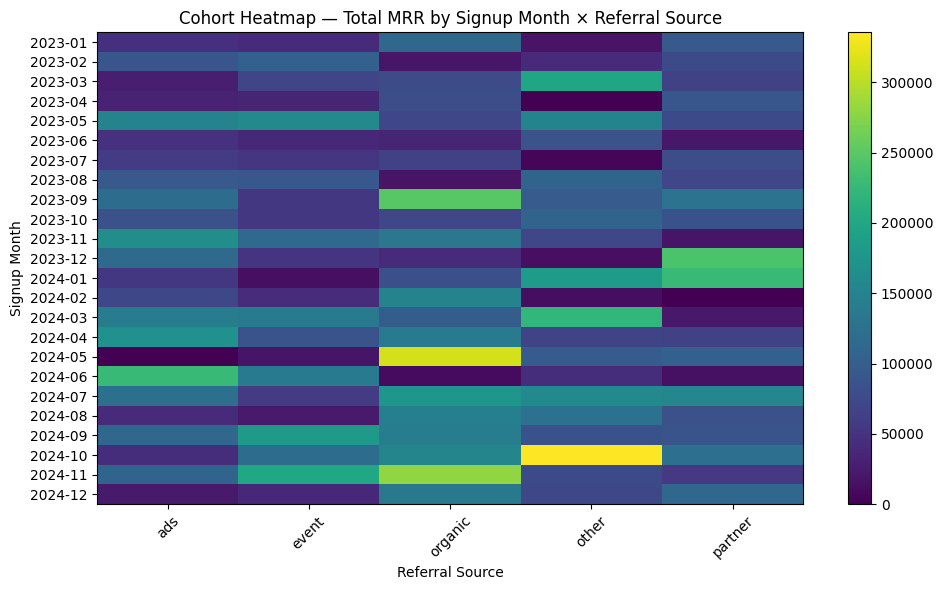

In [7]:
# Heatmap using default colormap (no explicit colors set)
plt.figure(figsize=(10,6))
data = pivot_total.fillna(0).values
plt.imshow(data, aspect="auto")
plt.title("Cohort Heatmap — Total MRR by Signup Month × Referral Source")
plt.xlabel("Referral Source")
plt.ylabel("Signup Month")
plt.xticks(ticks=range(len(pivot_total.columns)), labels=pivot_total.columns, rotation=45)
plt.yticks(ticks=range(len(pivot_total.index)),   labels=pivot_total.index.astype(str))
plt.colorbar()
plt.tight_layout()
plt.savefig('Cohort Heatmap')
plt.show()


## Line chart: average MRR per account over time by referral

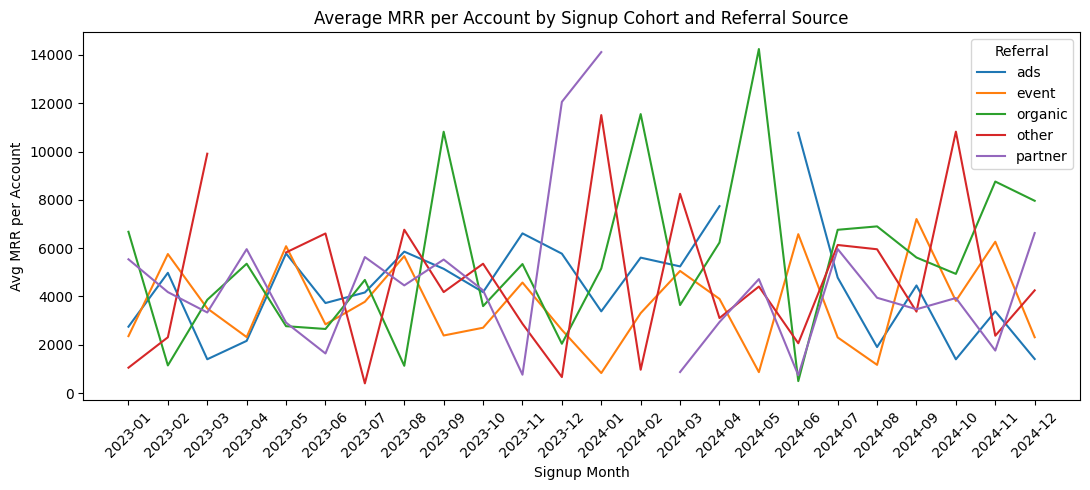

In [8]:
plt.figure(figsize=(11,5))
for col in pivot_peracct.columns:
    plt.plot(pivot_peracct.index.astype(str), pivot_peracct[col], label=col)
plt.xticks(rotation=45)
plt.title("Average MRR per Account by Signup Cohort and Referral Source")
plt.xlabel("Signup Month")
plt.ylabel("Avg MRR per Account")
plt.legend(title="Referral")
plt.tight_layout()
plt.savefig('Cohort Line Chart')
plt.show()


## Channel ranking: which referral brings highest-value customers?

In [9]:
# Rank channels by average mrr_per_acct across all cohorts (exclude empty)
channel_rank = (cohort_rev
                .dropna(subset=["mrr_per_acct"])
                .groupby("referral_source")["mrr_per_acct"]
                .mean()
                .sort_values(ascending=False)
                .reset_index())

print("Referral channels ranked by average MRR per account:")
print(channel_rank.to_string(index=False))


Referral channels ranked by average MRR per account:
referral_source  mrr_per_acct
        organic   5514.022721
          other   4745.509708
        partner   4580.310627
            ads   4461.263476
          event   3675.199195


## Cumulative revenue by referral channel (across calendar time)

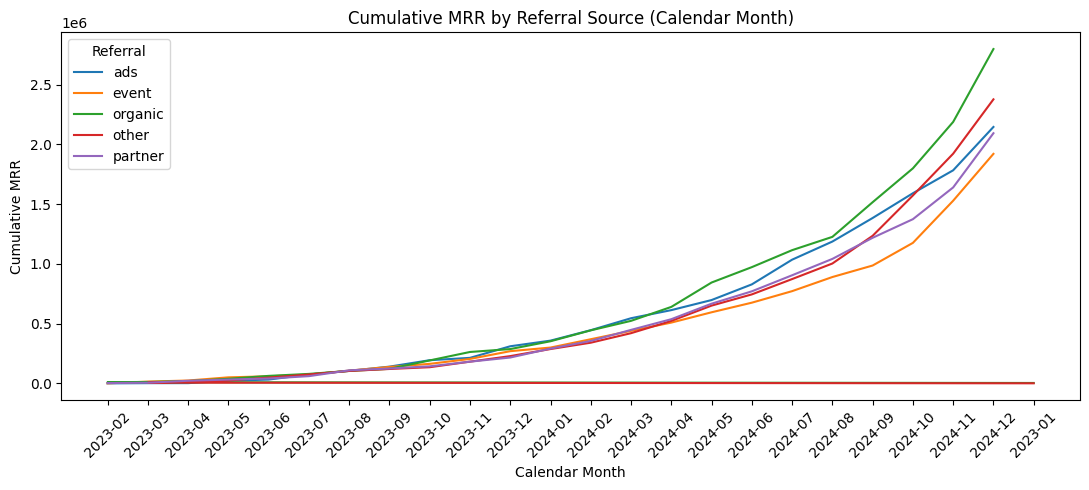

In [11]:
# Calendar month from subscription start, sum MRR per calendar month × referral
subs_month = df.copy()
subs_month["calendar_month"] = subs_month["start_date"].dt.to_period("M")
cal_month_rev = (subs_month.groupby(["calendar_month","referral_source"])["mrr_amount"]
                 .sum()
                 .reset_index()
                 .sort_values(["referral_source","calendar_month"]))

# Cumulative sum by referral
cal_month_rev["cum_mrr"] = (cal_month_rev
                            .groupby("referral_source")["mrr_amount"]
                            .cumsum())

# Plot cumulative revenue curves
plt.figure(figsize=(11,5))
for src, g in cal_month_rev.groupby("referral_source"):
    plt.plot(g["calendar_month"].astype(str), g["cum_mrr"], label=src)
plt.xticks(rotation=45)
plt.title("Cumulative MRR by Referral Source (Calendar Month)")
plt.xlabel("Calendar Month")
plt.ylabel("Cumulative MRR")
plt.legend(title="Referral")
plt.tight_layout()
plt.savefig('Cumulative revenue')
plt.show()
